In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Step 1: Install and import
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# Step 1: Load and Clean the Dataset


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')
# or commnent the above and run this instead if you upload the csv from ur local machine
#df = pd.read_csv('amazon_products_sample_500.csv')



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   28332 non-null  object 
 1   dateAdded            28332 non-null  object 
 2   dateUpdated          28332 non-null  object 
 3   name                 28332 non-null  object 
 4   asins                28332 non-null  object 
 5   brand                28332 non-null  object 
 6   categories           28332 non-null  object 
 7   primaryCategories    28332 non-null  object 
 8   imageURLs            28332 non-null  object 
 9   keys                 28332 non-null  object 
 10  manufacturer         28332 non-null  object 
 11  manufacturerNumber   28332 non-null  object 
 12  reviews.date         28332 non-null  object 
 13  reviews.dateSeen     28332 non-null  object 
 14  reviews.didPurchase  9 non-null      object 
 15  reviews.doRecommend  16086 non-null 

In [6]:
df[['name', 'categories']].head()

,name,categories
0,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C..."
1,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C..."
2,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C..."
3,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C..."
4,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C..."


# Step 2: Prepare the Text for Clustering


In [7]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('wordnet')

import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Define the advanced cleaning function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)

    # Convert to lowercase
    text = text.lower()

    # Replace/remove common words and product specs
    text = re.sub(r'allnew', '', text)
    text = re.sub(r'\d+gb', '', text)  # remove things like 32gb, 64gb
    text = re.sub(r'display', '', text)
    text = re.sub(r'wifi', '', text)
    text = re.sub(r'hd', '', text)
    text = re.sub(r'back', '', text)
    text = re.sub(r'gb', '', text)
    text = re.sub(r'ip', '', text)
    text = re.sub(r'aaa', '', text)
    text = re.sub(r'aa', '', text)
    text = re.sub(r'ad', '', text)

    # Remove special characters (keeping only letters, spaces, commas)
    text = re.sub(r'[^a-z\s,]', '', text)

    # Split by commas (your text has both name + categories)
    categories = [cat.strip() for cat in text.split(',') if cat.strip()]

    # Prepare NLP tools
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english') + [
        'new', 'misc', 'offer', 'offers', 'magenta',
        'fire', 'special', 'miscellaneous', 'other',
        'includes', 'including', 'amazon', 'back',
        'allnew', 'wifi'
    ])
    pattern = re.compile('[%s]' % re.escape(string.punctuation))

    cleaned_categories = []
    for cat in categories:
        words = cat.split()
        filtered_words = [
            lemmatizer.lemmatize(pattern.sub('', word))
            for word in words
            if word not in stop_words and len(word) > 1
        ]
        if filtered_words:
            cleaned_categories.append(' '.join(filtered_words))

    return ', '.join(cleaned_categories)

# Combine name and categories just like before
df['text_for_clustering'] = df['name'].fillna('') + ' ' + df['categories'].fillna('')

# Apply the new advanced cleaning
df['text_for_clustering'] = df['text_for_clustering'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Step 3: Generate Sentence Embeddings with BERT

In [8]:
# Use Sentence-BERT to encode product descriptions into semantic vectors

# !pip install -q sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and effective
# Convert cleaned text into embeddings
embeddings = model.encode(df['text_for_clustering'].fillna('').tolist(), show_progress_bar=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/886 [00:00<?, ?it/s]

#  Step 4: Cluster the Embeddings with HDBSCAN

In [9]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=150, prediction_data=True)
df['cluster'] = clusterer.fit_predict(embeddings)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Step 4.1: Analyze The HDBSCAN Clusters

In [10]:

# How many clusters were found?
n_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'] else 0)
print(f" Number of clusters found: {n_clusters}")

# How many noise points (label == -1)?
n_noise = sum(df['cluster'] == -1)
print(f" Number of noise points (outliers): {n_noise}")

# Show how many products in each cluster
cluster_sizes = df['cluster'].value_counts().sort_index()
print("\n📈 Cluster Sizes:")
print(cluster_sizes)


 Number of clusters found: 22
 Number of noise points (outliers): 709

📈 Cluster Sizes:
cluster
-1      709
 0     8343
 1     3728
 2      617
 3      233
 4     1425
 5      304
 6      223
 7     1676
 8     2443
 9      293
 10    1212
 11     178
 12     541
 13     745
 14     156
 15     883
 16     242
 17     184
 18     803
 19    2370
 20    1024
Name: count, dtype: int64


In [11]:
from sklearn.metrics import silhouette_score

# Filter out noise points
mask = df['cluster'] != -1
score = silhouette_score(embeddings[mask], df.loc[mask, 'cluster'])
print(f"Silhouette Score: {score:.2f}")


Silhouette Score: 0.99


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


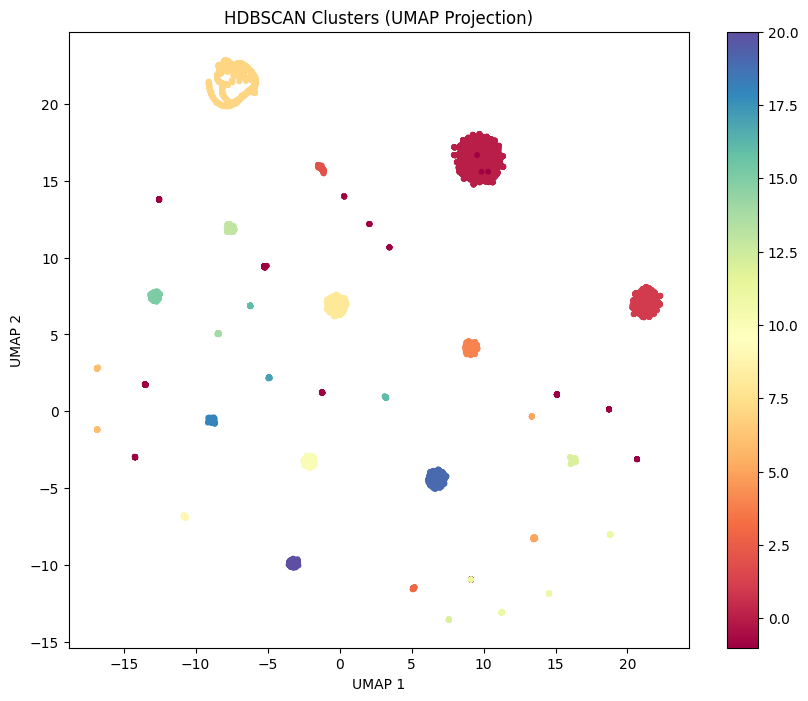

In [12]:
import umap
import matplotlib.pyplot as plt

# Reduce dimensions to 2D
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.0, metric='cosine')
umap_embeddings = umap_model.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=df['cluster'],           # Color by cluster
    cmap='Spectral',           # Nice color map
    s=10                       # Size of points
)
plt.colorbar(scatter)
plt.title('HDBSCAN Clusters (UMAP Projection)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


In [13]:
from collections import Counter

# Clean a list of words
def clean_keywords(words):
    cleaned = []
    for word in words:
        # Apply your clean_text function (or simple clean here)
        word = clean_text(word)  # reuse your clean_text function
        if word:  # if not empty after cleaning
            cleaned.append(word)
    return cleaned

# Function to get top cleaned keywords per cluster
def get_cleaned_top_keywords(df, text_column, cluster_column, top_n=10):
    cluster_keywords = {}

    for cluster in sorted(df[cluster_column].unique()):
        if cluster == -1:
            continue  # Skip noise

        cluster_texts = df[df[cluster_column] == cluster][text_column]

        all_words = ' '.join(cluster_texts).split()

        counter = Counter(all_words)
        most_common = counter.most_common(top_n)

        # Clean the top keywords
        raw_keywords = [word for word, count in most_common]
        cleaned_keywords = clean_keywords(raw_keywords)

        cluster_keywords[cluster] = cleaned_keywords

    return cluster_keywords

# Apply it
cleaned_top_keywords = get_cleaned_top_keywords(df, text_column='text_for_clustering', cluster_column='cluster', top_n=10)

# Display nicely
for cluster_id, keywords in cleaned_top_keywords.items():
    print(f"Cluster {cluster_id}: {', '.join(keywords)}")


Cluster 0: battery, health, household, battery, health, camera, amazonbasics, performance, alkaline, count
Cluster 1: battery, health, household, battery, health, camera, amazonbasics, performance, alkaline, count
Cluster 2: home, smart, speaker, electronics, bluetooth, home, accessory, mp, audio, device
Cluster 3: tablet, kid, tablet, electronics, edition, blue, kidproof, case, computerstablets, networking
Cluster 4: tablet, kid, case, computer, electronics, edition, blue, kidproof, computer, electronics
Cluster 5: tablet, ereers, kindle, electronics, ebook, tablet, ereer, glarefree, touchscreen, electronics
Cluster 6: tablet, blue, tablet, computer
Cluster 7: tablet, kid, toy, electronics, edition, pink, kidproof, case, learning, tech
Cluster 8: tablet, tablet, alexa, tangerine, genuine, accessory, computer, electronics
Cluster 9: tablet, kid, edition, pink, kidproof, case, computer, tablet
Cluster 10: tablet, kid, edition, green, kidproof, case, computer, tablet
Cluster 11: kindle, 

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import numpy as np

class BestKFinder:
    def __init__(self, k_min=None, k_max=None):
        self.k_min = k_min
        self.k_max = k_max
        self.best_k = None
        self.best_score = None
        self.best_labels = None

    def fit(self, X, hdbscan_labels):
        # Filter out noise points
        mask = hdbscan_labels != -1
        X_filtered = X[mask]
        X_normalized = normalize(X_filtered)

        # Get number of clusters found by HDBSCAN
        n_clusters_hdbscan = len(np.unique(hdbscan_labels[mask]))

        # Auto set k_min and k_max if not provided
        if self.k_min is None or self.k_max is None:
            self.k_min = 2
            self.k_max = max(2, n_clusters_hdbscan // 2)  # 50% of HDBSCAN clusters

        best_k = None
        best_score = -1
        best_labels = None

        for k in range(self.k_min, self.k_max + 1):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
            current_labels = kmeans.fit_predict(X_normalized)
            score = silhouette_score(X_normalized, current_labels, metric='cosine')

            if score > best_score:
                best_k = k
                best_score = score
                best_labels = current_labels

        self.best_k = best_k
        self.best_score = best_score
        self.best_labels = best_labels

    def get_best_k(self):
        return self.best_k

    def get_best_score(self):
        return self.best_score

    def get_labels(self):
        return self.best_labels


In [15]:
# 1. Create an instance of BestKFinder
k_finder = BestKFinder()

# 2. Fit it with your embeddings and HDBSCAN labels
k_finder.fit(embeddings, df['cluster'])

# 3. Print the best number of clusters and silhouette score
print("Best K:", k_finder.get_best_k())
print("Best Silhouette Score:", k_finder.get_best_score())

# 4. Get the new labels (from KMeans using the best K)
best_labels = k_finder.get_labels()


Best K: 10
Best Silhouette Score: 0.8850082


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


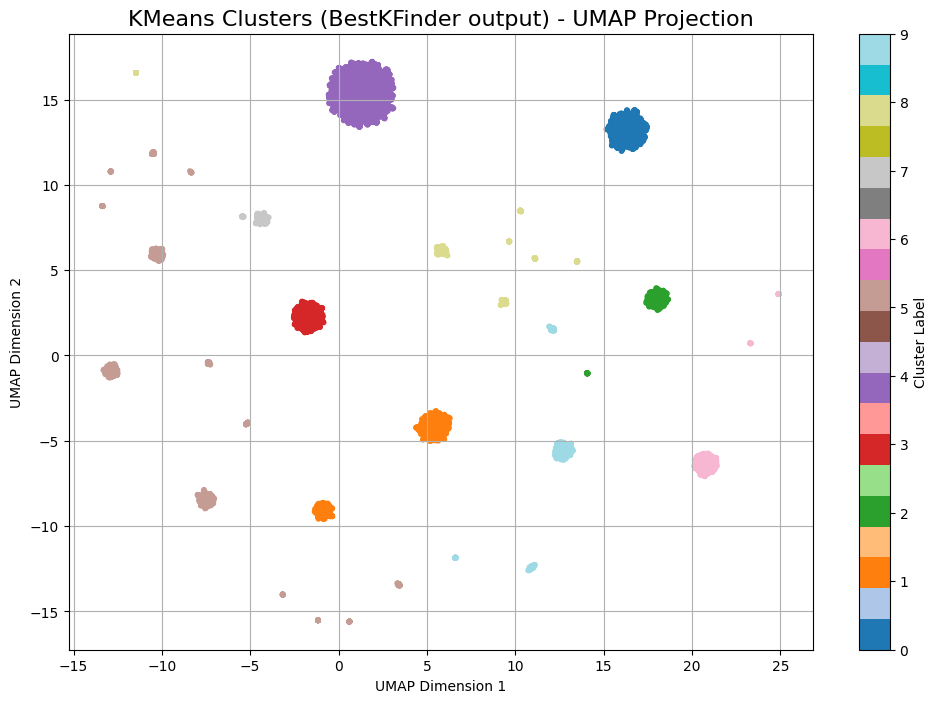

In [16]:
# Install UMAP if you don't have it already
# !pip install umap-learn

import umap
import matplotlib.pyplot as plt

# Step 1: Filter out noise points (optional but safer)
mask = df['cluster'] != -1
X_filtered = embeddings[mask]
best_labels_filtered = best_labels  # these are from KMeans after BestKFinder

# Step 2: Apply UMAP to reduce dimensions
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_filtered)

# Step 3: Plot the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=best_labels_filtered, cmap='tab20', s=10)

plt.title('KMeans Clusters (BestKFinder output) - UMAP Projection', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()
